# Alzheimer prediction using gray matter density from T1w MRI 

**Deadline**: Upload this notebook (rename it as 'TP-Trees-YOUR-SURNAME.ipynb') with your answers and the code before the deadline.

We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier



     |████████████████████████████████| 3.1MB 5.7MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
dest_path='./dataTP.npz')
gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
dest_path='./AtlasAAL2.nii')
gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
dest_path='./AtlasAICHA.nii')
gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS 

In [93]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

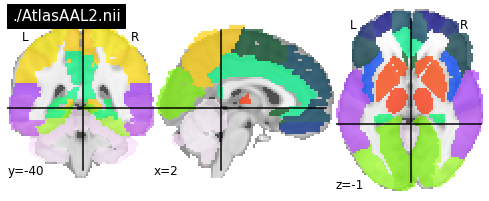

In [4]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [71]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.3, random_state=42)

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used. 

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training. 

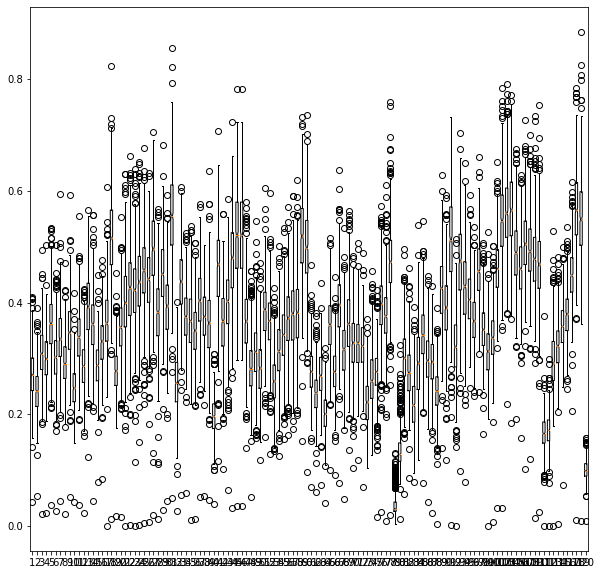

In [72]:
plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True);
# As we can see features only have positive values, so we will use a normalization.
# Standardization/Normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Normalize data (each feature will be scaled into the range 0,1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Then, we can fit a Decision tree, with the default setting, using the following code:

In [34]:
# Fitting Decision Trees 
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7389380530973452


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ? 


**Answer:**

As we can see bellow, the best value would be the one that minimizes the test error, that is, is able to correctly fit and generalize our model. In the min_samples_split this means 11 and for the min_samples_leaf it is 10. This makes sense as setting a higher minimum better generalizes our model. (letting a leaf have 1 or 2 samples may lead to overfitting).

 The improvement in the result for the min_samples_leaf is more relevant, but we can see that they overall don’t change drastically. When we test with a different split (different random state), the best values changes, but again, the values of error don’t doesn’t change so drastically overall.


The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  11


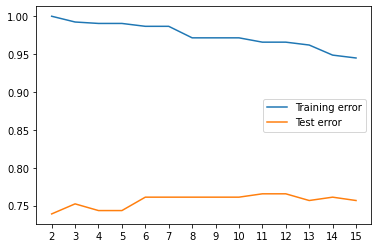

In [35]:
# min_samples_split

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    Tree.fit(X_train,y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  10


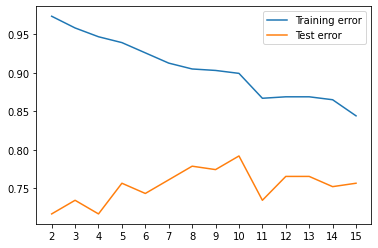

In [36]:
# min_samples_leaf

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0)
    Tree.fit(X_train,y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

Try to add Gaussian noise to the data (using for instance zero mean and 0.05 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise. 

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

**Answer:**

No, as can be seen in the graph bellow, the results aren’t stable. Usually adding the noise make the results worst, which is expected.

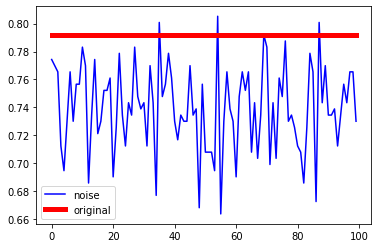

In [39]:
Tree = DecisionTreeClassifier(min_samples_split=11,min_samples_leaf=10,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train,y_train)
scoreTest[:] = Tree.score(X_test,y_test)  

for k in range(100):    
    X_train_temp=np.copy(X_train)
    for i in range(X_train.shape[0]):
        X_train_temp[i] += np.abs(np.random.normal(0, 0.05))
        
    Tree.fit(X_train_temp,y_train)
    scoreTestnoise[k] = Tree.score(X_test,y_test)
    
plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')       
plt.legend();

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

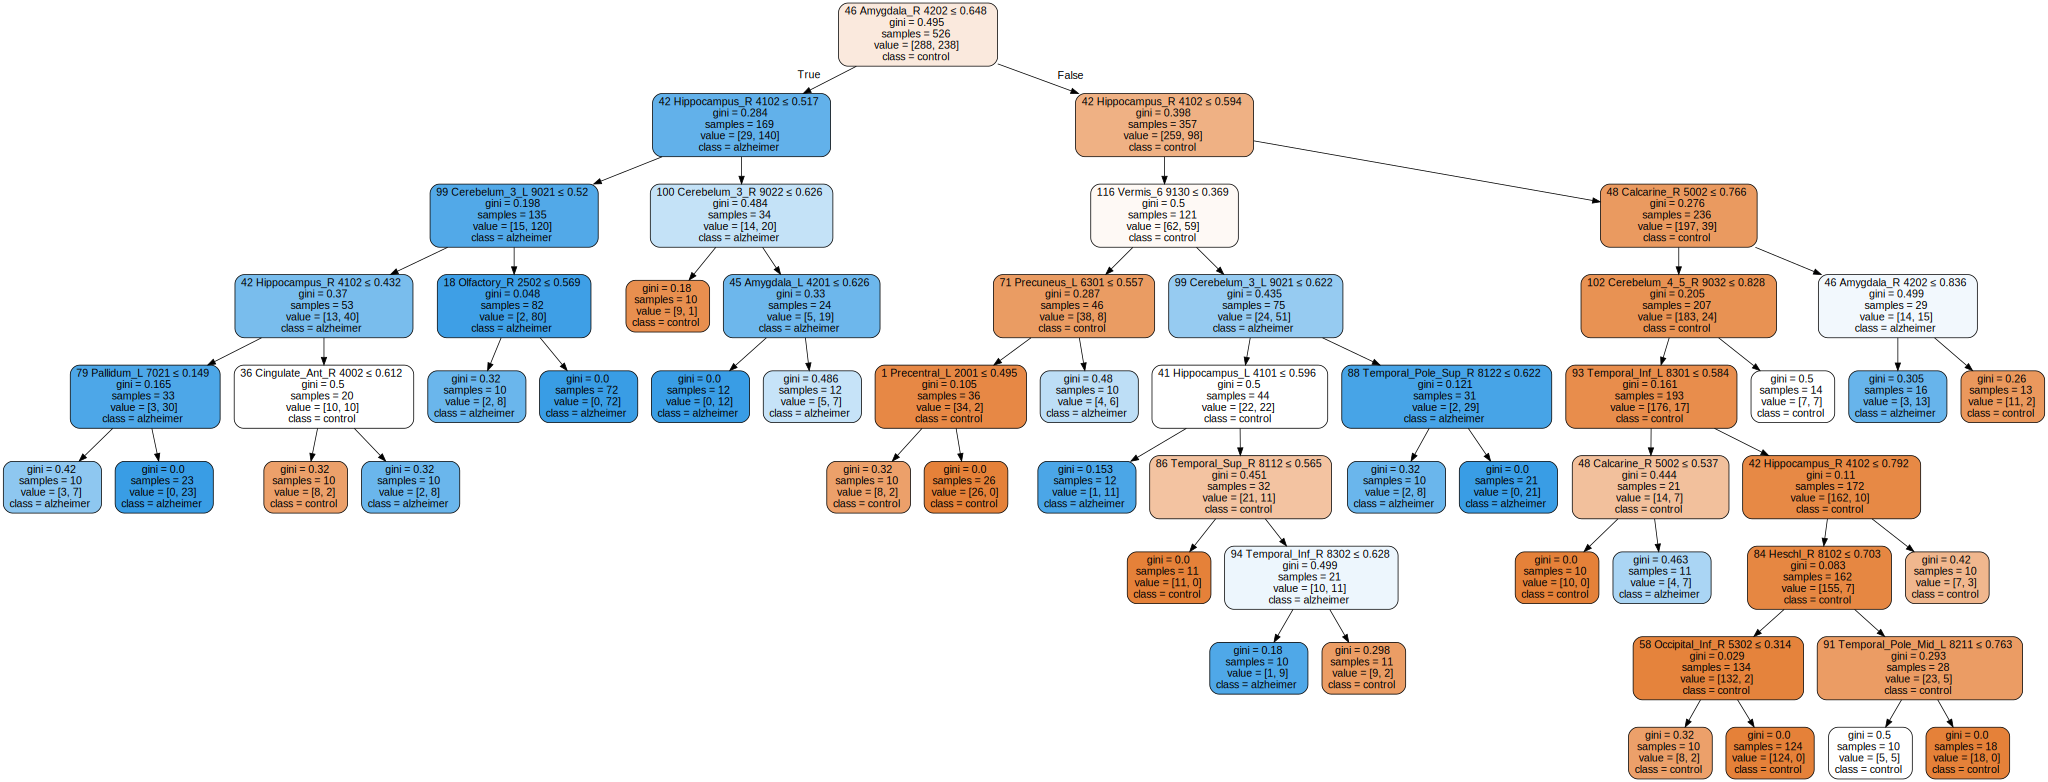

In [53]:
import graphviz 

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

**Answer:**

As can be seen bellow, adding noise to the data changes the resulting tree. If the noise is small, the levels closer to the root of the tree seems to stay the same, just the lower ones vary. But if we increase the level of noise, the changes will become more drastically.

This is due to the fact that no global optimization (NP-complete) we use a greedy algorithm where locally optimal decisions are made. That is, we have a model with high interpretability, but isn’t so stable. (A small change in (all) input data can bring to a completely different tree (noisy) ! This instability is due to the hierarchical nature of the process.)


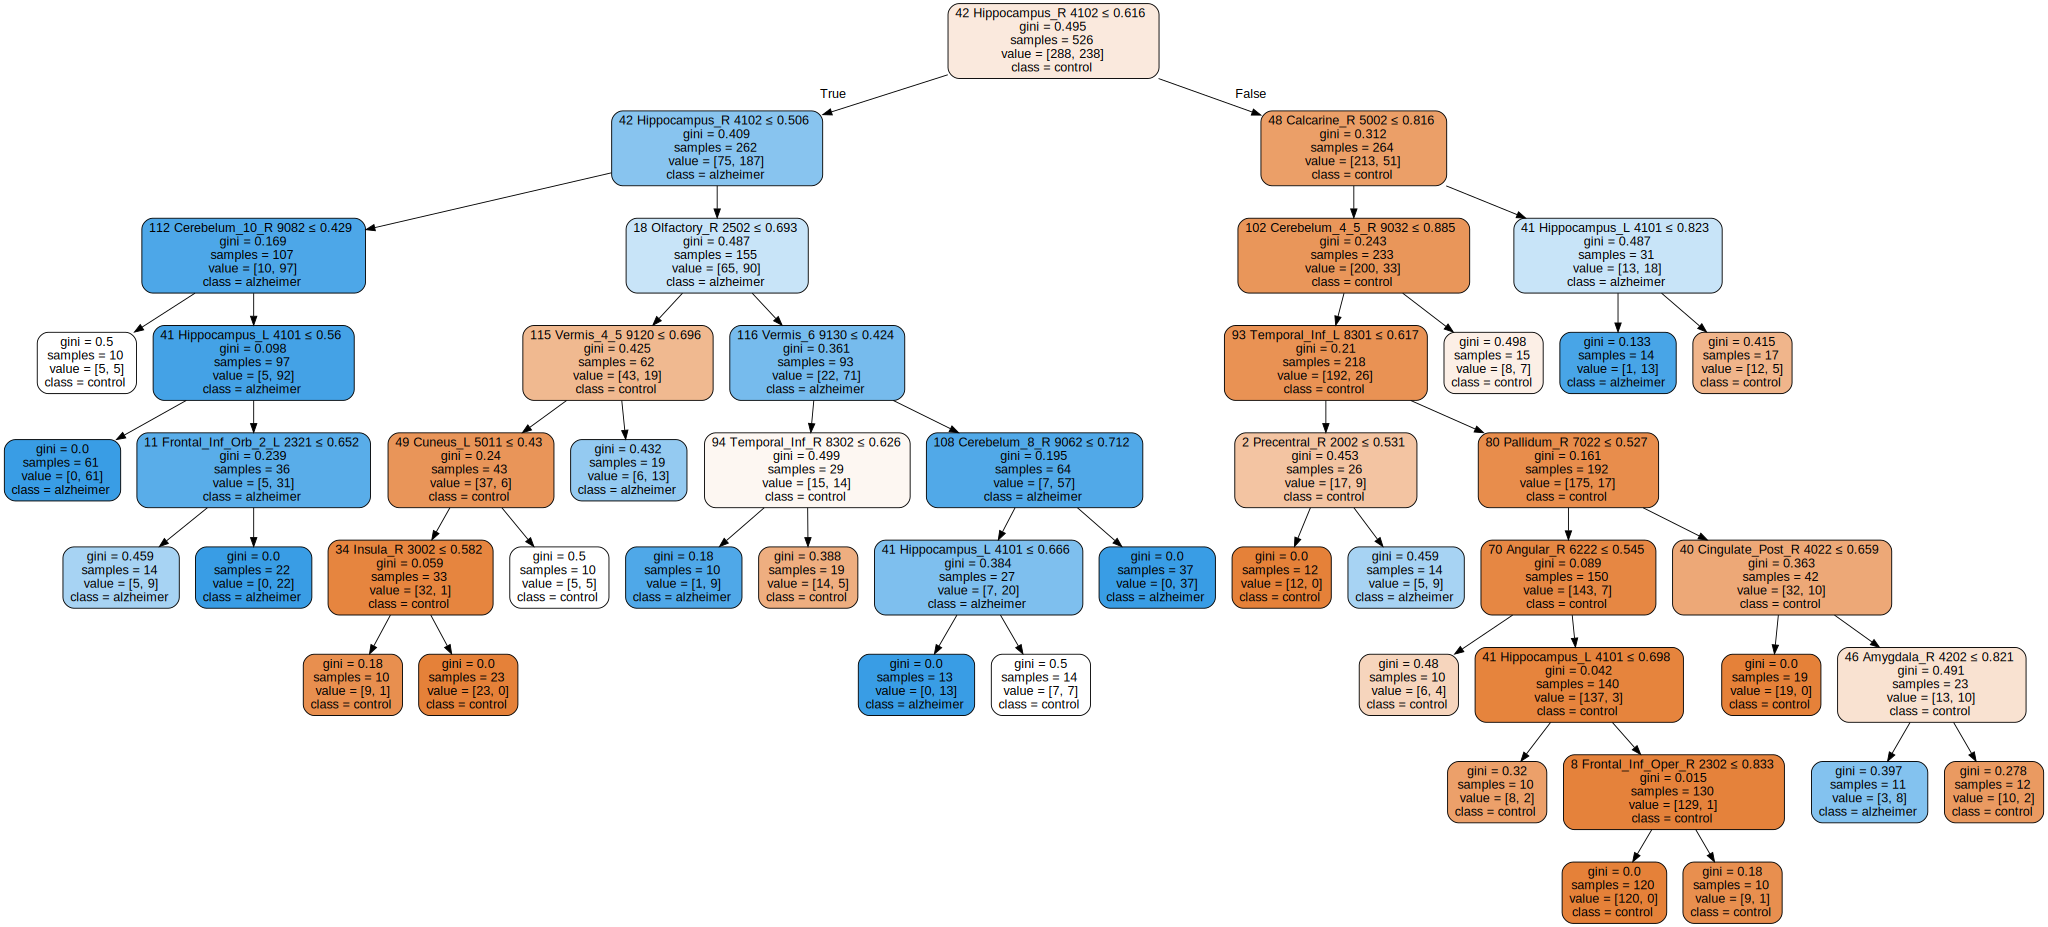

In [56]:
X_train_temp=np.copy(X_train)
for i in range(X_train.shape[0]):
    X_train_temp[i] += np.abs(np.random.normal(0, 0.05))

Tree.fit(X_train_temp,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way. 

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**Answer:**

No, the hyper parameters found using cross validation aren’t the same. That is because our model varies a lot, so depending on the random split in CV, the results will be different.

Testing different metrics such as f1, precision, recall, didn’t seem to improve our results.

In [68]:
Tree = DecisionTreeClassifier()
p_grid_tree = {'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
              'min_samples_leaf': [2,3,4,5,6,7,8,9,10,11,12,13,14,15] }
grid_tree = GridSearchCV(estimator=Tree, param_grid=p_grid_tree, cv=5,scoring="accuracy")
grid_tree.fit(X_train,y_train)
best_params= grid_tree.best_params_
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test,y_test))

Best Validation Score: 0.7452830188679245
Best params: {'min_samples_leaf': 15, 'min_samples_split': 3}
Tree test score : 0.7610619469026548


Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library. 

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

**Answer:**

As in the case of the addition of noise, the nodes close to the root tent to be the same, and the tree start to vary more as we descend. Yes, usually the same ROIs can be seen on the top, meaning that this are truly the most important features in the prediction of Alzheimer. 

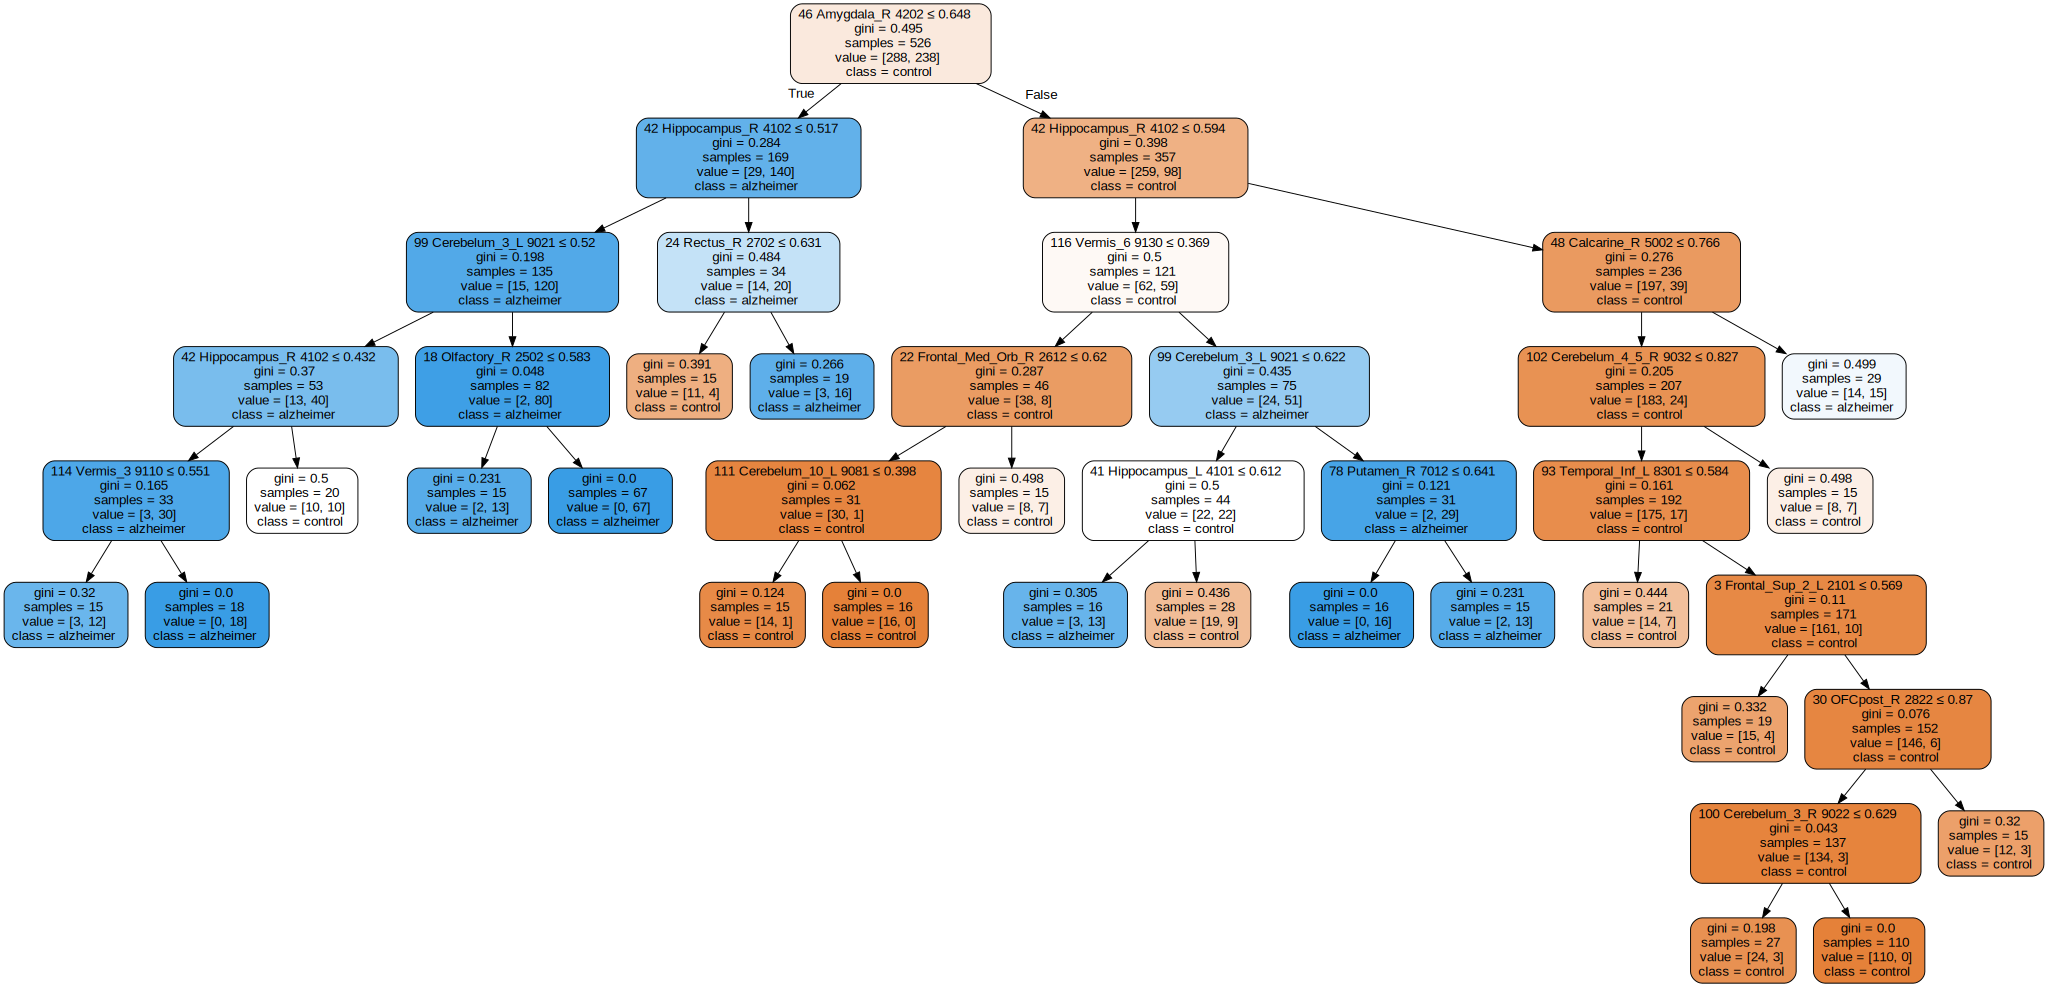

In [69]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. 

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

**Answer:**

There is no big difference between the original and noise data results. For both cases we found the same best parameter, this signalizes that bagging might be a more robust model than decision tree.

As for the scores, the improve a little bit compered to the decision tree. This difference becomes more significant when we look into the noise case.




In [73]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, cv=5,scoring="accuracy")
grid_bagging.fit(X_train,y_train)
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

Best Validation Score: 0.8042048517520215
Best params: {'n_estimators': 20}
Bagging test score : 0.827433628318584


In [75]:
# Bagging on noisy data
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

X_train_temp=np.copy(X_train)
for i in range(X_train.shape[0]):
    X_train_temp[i] += np.abs(np.random.normal(0, 0.05))

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, cv=5,scoring="accuracy")
grid_bagging.fit(X_train_temp,y_train)
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

Best Validation Score: 0.798418688230009
Best params: {'n_estimators': 20}
Bagging test score : 0.8185840707964602


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [77]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train,y_train)

best_params_f= grid_RF.best_params_

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

Best Validation Score: 0.8268823000898472
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 30}
Random Forest test score : 0.8185840707964602


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging. 

**Answer:**

The results for the test set almost don’t vary when we use the noisy data, this shows that it is an even more robust model than bagging. But for the quality of the result, it’s again almost the same as the bagging one, which is not so much better than the decision tree best scenario.

In [79]:
# Random Forest on noisy data
X_train_temp=np.copy(X_train)
for i in range(X_train.shape[0]):
    X_train_temp[i] += np.abs(np.random.normal(0, 0.05))

RF=RandomForestClassifier(max_features=best_params_f['max_features'],min_samples_leaf=best_params_f['min_samples_leaf'],n_estimators=best_params_f['n_estimators'],random_state=0)
RF.fit(X_train_temp,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(RF.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(RF.score(X_test,y_test)) )

Score in the training set is 0.8726235741444867
Score in the test set is 0.8185840707964602


We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 45 representing 46 Amygdala_R 4202
 (0.081412)
2. feature 44 representing 45 Amygdala_L 4201
 (0.078820)
3. feature 41 representing 42 Hippocampus_R 4102
 (0.061045)
4. feature 40 representing 41 Hippocampus_L 4101
 (0.050335)
5. feature 43 representing 44 ParaHippocampal_R 4112
 (0.029941)
6. feature 93 representing 94 Temporal_Inf_R 8302
 (0.026612)
7. feature 92 representing 93 Temporal_Inf_L 8301
 (0.025063)
8. feature 59 representing 60 Fusiform_R 5402
 (0.022801)
9. feature 42 representing 43 ParaHippocampal_L 4111
 (0.017602)
10. feature 81 representing 82 Thalamus_R 7102
 (0.016120)


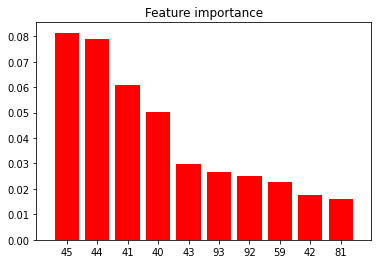

In [80]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense. 

**Answer:**

Firs in the 46 Amygdala_R 4202 and second is 45 Amygdala_L 4201.

Bellow are some extracts from the reference papers that confirm that biologically speaking, the amygdala is expected to have relevance in the Alzheimer prediction:

*  "driven by prior biological knowledge of regions typically affected by AD, such as the hippocampus, amygdala, thalamus, and caudate (Chu et al., 2012)""

*  "Recently, Tang et al. (2015) used shape diffeomorphometry of the left and right amygdala, hippocampus, thalamus, caudate, putamen, globus pallidus, and lateral ventricle for prediction of AD conversion using LDA."

We can also inspect the data using only pairs of the most important features

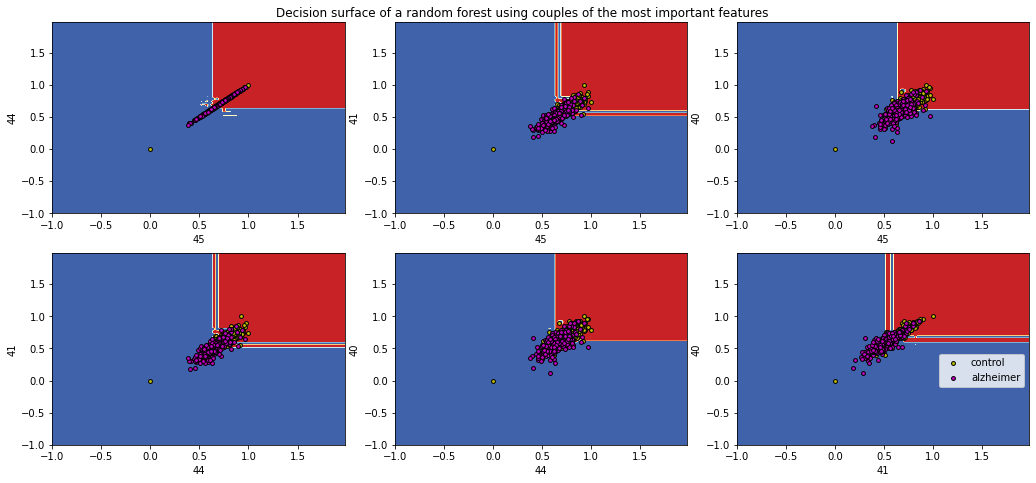

In [81]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?

**Answer:**

The 41-45 or the 41-44 pairs seems to give the best results. That is, they seem to give more right classifications according to our special subdivision.
 


**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

**Answer:**

The results for the AAL2 are similar to the ones obtained with HAMMERS, which are the ones confirmed by the papers as stated before: amygdala and hippocampus are in the top 5 for both Atlas. 

Now for the AICHA, the results don’t match with the previous Atlas, and not as much with the paper, its top ROI that matches is the thalamus.

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 192


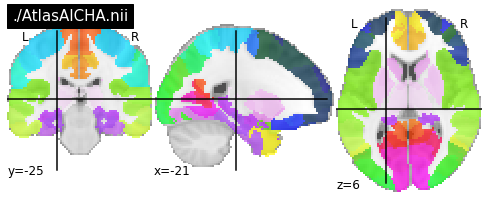

Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.059613)
2. feature 187 representing 188	N_Thalamus-5	189
 (0.034715)
3. feature 170 representing 171	G_Fusiform-6	172
 (0.033543)
4. feature 173 representing 174	N_Caudate-1	175
 (0.030426)
5. feature 188 representing 189	N_Thalamus-6	190
 (0.029430)
6. feature 189 representing 190	N_Thalamus-7	191
 (0.026932)
7. feature 112 representing 113	G_Supp_Motor_Area-3	114
 (0.019037)
8. feature 145 representing 146	S_Parietooccipital-5	147
 (0.018829)
9. feature 93 representing 94	G_Temporal_Inf-1	95
 (0.018314)
10. feature 120 representing 121	G_Cingulum_Ant-1	122
 (0.016269)


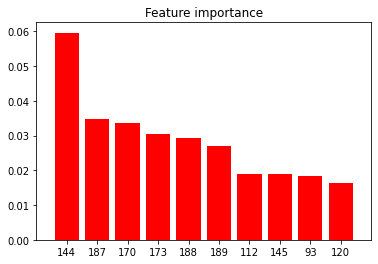

In [94]:
# Choose Atlas (here AICHA)
X=T1AICHA # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAICHA # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAICHA.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

plotting.plot_roi(atlas, title=atlas)
plotting.show()

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.3, random_state=42)
# Normalize data (each feature will be scaled into the range 0,1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train,y_train)

best_params_f= grid_RF.best_params_

RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
  print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 68


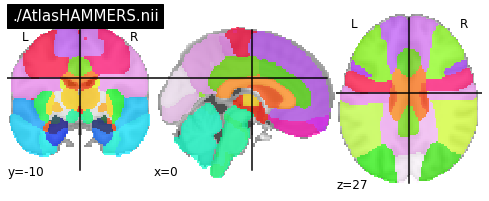

Feature ranking:
1. feature 3 representing Right Amygdala                         (0.129884)
2. feature 2 representing Left Amygdala                          (0.079852)
3. feature 46 representing Left Lateral Temporal Ventricle        (0.052282)
4. feature 1 representing Right Hippocampus                      (0.051854)
5. feature 0 representing Left Hippocampus                       (0.046257)
6. feature 47 representing Right Lateral Temporal Ventricle       (0.039432)
7. feature 12 representing Left Inferior Middle Temporal Gyri     (0.035729)
8. feature 5 representing Right Anterior Medial Temporal Lobe    (0.029229)
9. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.023855)
10. feature 4 representing Left Anterior Medial Temporal Lobe     (0.020808)


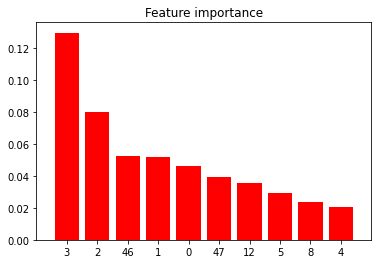

In [95]:
# Choose Atlas (here HAMMERS)
X=T1HAMMERS # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsHAMMERS # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasHAMMERS.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

plotting.plot_roi(atlas, title=atlas)
plotting.show()

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.3, random_state=42)
# Normalize data (each feature will be scaled into the range 0,1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train,y_train)

best_params_f= grid_RF.best_params_

RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
  print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()